In [73]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import tensorly as tl
from tensorly.decomposition import tucker
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
data = pd.read_csv('ratings.txt')

In [3]:
data=data.dropna()

In [6]:
#data['rating']=data['rating']/5
data.head()

,userid,itemid,rating,Time,Location,Companion
148,1003,tt0454876,1,Weekday,Cinema,Alone
149,1003,tt0120912,1,Weekday,Cinema,Alone
150,1003,tt3793764,1,Weekday,Cinema,Alone
151,1003,tt0114148,1,Weekday,Cinema,Alone
152,1003,tt0110357,1,Weekday,Cinema,Alone


In [21]:
data = data.sort_values(by=['userid', 'itemid'])
data.iloc[30:,:]

,userid,itemid,rating,Time,Location,Companion
1046,1002,tt0114369,3,Weekday,Home,Family
1054,1002,tt0114369,3,Weekend,Home,Partner
1048,1002,tt0120338,4,Weekday,Home,Family
1056,1002,tt0120338,5,Weekend,Home,Partner
1050,1002,tt0133093,4,Weekday,Home,Family
1058,1002,tt0133093,2,Weekend,Home,Partner
1044,1002,tt0266543,5,Weekday,Home,Family
1052,1002,tt0266543,4,Weekend,Home,Partner
1062,1002,tt0367594,5,Weekday,Home,Family
1066,1002,tt0367594,3,Weekday,Home,Partner


In [22]:
dataplot = data.copy()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataplot.iloc[:,4] = le.fit_transform(dataplot.iloc[:,4])
dataplot.iloc[:,5] = le.fit_transform(dataplot.iloc[:,5])
dataplot.iloc[:,3] = le.fit_transform(dataplot.iloc[:,3])
dataplot.iloc[:,1] = le.fit_transform(dataplot.iloc[:,1])
data2=dataplot.copy()

In [23]:
data2.head()

,userid,itemid,rating,Time,Location,Companion
723,1001,0,3,1,0,1
731,1001,0,4,1,0,2
721,1001,4,2,1,0,1
729,1001,4,3,1,0,2
737,1001,7,1,1,1,0


In [24]:
data2.shape

(3595, 6)

In [25]:
user_id = data2['userid'].unique()
item_id = data2['itemid'].unique()
location = data2['Location'].unique()
companion = data2['Companion'].unique()
time = data2['Time'].unique()

In [26]:
def mapping(ids):
    count = 0
    keys_u = ids
    map_array = {}
    for i in keys_u:
        map_array[i] = count
        count = count + 1
    return map_array

In [27]:
map_users = mapping(user_id)
map_items = mapping(item_id)
map_loc = mapping(location)
map_tim = mapping(time)
map_com = mapping(companion)

In [28]:
tensor5d = np.zeros([len(user_id),len(item_id),len(location),len(time),len(companion)])
tuck = np.zeros([len(user_id),len(item_id),len(location),len(time),len(companion)])

In [29]:
for i in range(data2.shape[0]):
    idx1 = map_users[data2.iloc[i,0]]
    idx2 = map_items[data2.iloc[i,1]]
    idx3 = map_loc[data2.iloc[i,4]]
    idx4 = map_tim[data2.iloc[i,3]]
    idx5 = map_com[data2.iloc[i,5]]
    rat = data2.iloc[i,2]
    tensor5d[idx1,idx2,idx3,idx4,idx5] = rat

In [30]:
factors5d = tucker(tensor5d , ranks=[20,20,2,2,3])

In [31]:
len(factors5d[0])

20

In [32]:
factors5d[0].shape

(20, 20, 2, 2, 3)

In [37]:
from tensorly import tucker_to_tensor
tuck=tucker_to_tensor(factors5d)
tuck.shape

(81, 79, 2, 2, 3)

In [128]:
Newtensor_ratings=[]
for i in range(data2.shape[0]):
    idx1 = map_users[data2.iloc[i,0]]
    idx2 = map_items[data2.iloc[i,1]]
    idx3 = map_loc[data2.iloc[i,4]]
    idx4 = map_tim[data2.iloc[i,3]]
    idx5 = map_com[data2.iloc[i,5]]
    rat = data2.iloc[i,2]
    new_rat= tuck[idx1,idx2,idx3,idx4,idx5]
    Newtensor_ratings.append(new_rat)


In [129]:
Newtensor_ratings=np.array(Newtensor_ratings)
Newtensor_ratings.shape

(3595,)

In [130]:
from math import sqrt

rmse = sqrt(mean_squared_error(data2.iloc[:,2],Newtensor_ratings ))
print(rmse)

2.110404020490083


In [131]:
for i in range(len(Newtensor_ratings)):
    print(data2.iloc[i,2],Newtensor_ratings[i] )

3 0.684010663993
4 0.742985355058
2 0.428187359217
3 0.854721389931
1 0.0348185830944
1 -0.138351397627
2 0.345244287992
3 0.447851144552
2 0.195933076464
3 0.248942407896
4 0.752315403744
4 0.637505697092
1 0.0438910764547
1 -0.0164809201501
2 0.265083652872
4 0.483559602899
1 0.22252885361
1 0.0701679758533
2 0.381838994073
5 0.025457249191
1 0.277599844357
1 -0.0666444918107
4 0.291679768605
4 0.184367297382
1 0.0470139998003
1 0.107576988907
5 1.56796814688
4 0.633278964003
4 1.34173372367
5 0.637573303299
3 0.486946417242
3 0.237344658484
4 1.0237782024
5 0.466024663607
4 1.17168757007
2 0.579736956419
5 1.32106003291
4 0.998918039225
5 0.595618698385
3 -0.0550753311904
3 0.557707209999
4 0.286082310253
3 1.10051511779
3 0.166280990477
2 0.77748880503
1 0.173310445122
3 0.363768212907
3 0.0743857232251
3 1.52000850301
3 1.30664090825
1 0.22217426072
1 0.376926995494
1 0.220134959656
1 0.309818278769
1 0.134106273942
1 0.320884641443
1 0.00324450299027
1 0.100016916606
1 0.29998059

# Selecting Best Rank

In [75]:
bestRank=0
mae =[]
rms=[]
error=1000000
for rank in range(1,51):
    factors5d = tucker(tensor5d , ranks=[rank,rank,2,2,3])
    tuck=tucker_to_tensor(factors5d)
    Newtensor_ratings=[]
    for i in range(data2.shape[0]):
        idx1 = map_users[data2.iloc[i,0]]
        idx2 = map_items[data2.iloc[i,1]]
        idx3 = map_loc[data2.iloc[i,4]]
        idx4 = map_tim[data2.iloc[i,3]]
        idx5 = map_com[data2.iloc[i,5]]
        rat = data2.iloc[i,2]
        new_rat= tuck[idx1,idx2,idx3,idx4,idx5]
        Newtensor_ratings.append(new_rat)
    rmse = math.sqrt(mean_squared_error(data2.iloc[:,2],Newtensor_ratings ))
    mae.append(mean_absolute_error(data2.iloc[:,2],Newtensor_ratings ))
    rms.append(rmse)
    
    print(rank,rmse)
    if(rmse<error):
        error=rmse
        bestRank=rank
print(bestRank, error)

1 3.267483950731651
2 3.1575957394865357
3 3.0515320141290836
4 2.9469459067061825
5 2.8559769994002284
6 2.787171206067492
7 2.724386057244774
8 2.663115000521979
9 2.604888386278612
10 2.543784784455374
11 2.506887959216064
12 2.44675776820087
13 2.3870983550783276
14 2.348829823647784
15 2.308980442847266
16 2.2758036636859917
17 2.2514228652461767
18 2.215929769600599
19 2.1720468091722154
20 2.1104040204900834
21 2.0551794775280325
22 2.02106004706307
23 1.9692727290347685
24 1.9396291562676156
25 1.8929534393840768
26 1.8679940514828353
27 1.8160269089440437
28 1.7673453512073818
29 1.7309379513367082
30 1.6924571020605894
31 1.6533866009928513
32 1.6171962112438667
33 1.5732780832063138
34 1.533655620541712
35 1.490293405577504
36 1.454985651759536
37 1.417127016288243
38 1.3799718398698524
39 1.335417658647507
40 1.3051007830974504
41 1.2709188315123194
42 1.236781500170292
43 1.2001413524874283
44 1.1680777399138904
45 1.1374030874041194
46 1.1050047322681469
47 1.071792982875

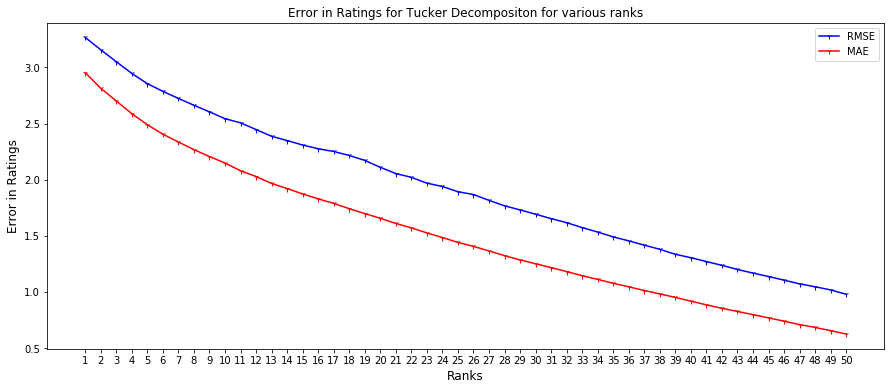

In [91]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(1,51), rms, marker='1', color='blue')
plt.plot(np.arange(1,51), mae, marker='1', color='red')
plt.legend(['RMSE', 'MAE'])
plt.xlabel("Ranks", fontsize=12)
plt.ylabel("Error in Ratings", fontsize=12)
plt.xticks(np.arange(1,51))
plt.title("Error in Ratings for Tucker Decompositon for various ranks")
plt.show()

In [111]:
for i in range(len(Newtensor_ratings)):
    print(data2.iloc[i,2],Newtensor_ratings[i] )

3 1.05755093194
4 1.61800920165
2 0.631262170144
3 1.03849904579
1 0.2227252561
1 0.107009141927
2 1.3780478538
3 1.48828179804
2 0.654324897962
3 0.603151167168
4 1.46298175974
4 1.60035378957
1 0.0796461315585
1 0.00749773100078
2 0.476445686825
4 0.860972130636
1 0.275514851023
1 0.0596140861091
2 0.779788094851
5 0.484428022086
1 0.237108418279
1 0.202882388016
4 0.528221375487
4 1.01970556754
1 0.0759276256073
1 0.117152314556
5 2.41034281419
4 1.7857976159
4 2.24585668602
5 2.66257287798
3 1.46728601573
3 0.942723140544
4 2.64830529924
5 2.44276118658
4 2.08436972352
2 0.922520887077
5 2.35224549402
4 2.35951500932
5 2.14523395493
3 0.791279495078
3 1.55974855277
4 1.03420072069
3 2.7154643288
3 1.22254286779
2 1.51204861366
1 0.0374701145774
3 0.704522581071
3 0.276618738408
3 2.68540336802
3 2.24374298503
1 0.300852727277
1 0.488322544501
1 0.119425918168
1 0.440919495883
1 0.162613304227
1 0.281901017061
1 0.0128163927304
1 0.0441193239697
1 0.268054073073
1 0.367090911961
1 0